In [1]:
import urllib.request
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import zipfile
import os
import hard_debias as hd
import double_hard_debias as dhd
import utils
from weat import weat
import analogy_tasks as ana
import further_embeddings as data # takes a while because it loads all embedding datasets

successfully loaded double_hard_debias
successfully loaded utils
successfully loaded hard_debias
successfully loaded analogy_tasks
successfully loaded further_embeddings


In [2]:
# load the debiased embedding obtained by our implementation of Double-Hard Debias
with zipfile.ZipFile('debiased.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())
    file_1 = open('debiased.p', 'rb') 
    debiased_equal = pickle.load(file_1)
    file_1.close()
    
# load the Double-Hard debiased embeddings obtained by Wang et al. (2020)
file_2 = open('glove_dhd.p', 'rb') # can be downloaded from: http://www.cs.virginia.edu/~tw8cb/word_embeddings/
glove_dhd_wang = pickle.load(file_2)
file_2.close()

In [3]:
# preprocessing glove_dhd.p
embedding_dhd = np.asarray(list(glove_dhd_wang.values()))
vocab_dhd = list(glove_dhd_wang.keys())
w2id_dhd = {w: i for i, w in enumerate(vocab_dhd)}

In [4]:
dict_embeddings = {'original GloVe': (data.embedding, data.vocab, data.w2id), 'Double-Hard-GloVe (Wang et al.)': (embedding_dhd, vocab_dhd, w2id_dhd), 
                   'Double-Hard-GloVe (replication)': (debiased_equal, data.vocab, data.w2id),
                   'GN-Glove': (data.embedding_gn, data.vocab_gn, data.w2id_gn), 'GN-Glove(a)': (data.embedding_gn_a, data.vocab_gn_a, data.w2id_gn_a),
                   'GP-GloVe': (data.embedding_gp, data.vocab_gp, data.w2id_gp), 'GP-GN-GloVe': (data.embedding_gp_gn, data.vocab_gp_gn, data.w2id_gp_gn),
                   'Hard-GloVe': (data.embedding_hd, data.vocab_hd, data.w2id_hd), 'Strong-Hard-GloVe': (data.embedding_hd_a, data.vocab_hd_a, data.w2id_hd_a)
                  }

## Word Embedding Association Test
The Word Embedding Associatin Test (short WEAT) was introduced by [Caliskan, Bryson and Narayanan (2017)](https://arxiv.org/abs/1608.07187). It is a permutation test. Lower effect sizes `d` indicate less gender bias and p-values `p>0.05` indicate that the bias is insignificant. The word lists are taken from the original paper. The implementation is taken from https://github.com/shivaomrani/HumanBiasInSemantics with minor adjustments such as variable names for readability. See file `weat.py`.

In [5]:
# Career and family
male_names = ["john", "paul", "mike", "kevin", "steve", "greg", "jeff", "tom"] # change "bill" to "tom" as in Wang et al. to avoid ambiguity
female_names = ["amy", "joan", "lisa", "sarah", "diana", "kate", "ann", "donna"]
career_attributes = ["executive", "management", "professional", "corporation", "salary", "office", "business", "career"]
family_attributes = ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives"]

In [6]:
# Math and arts
math_words = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "addition"]
arts_words1 = ["poetry", "art", "dance", "literature", "novel", "symphony", "drama", "sculpture"]
male_attributes1 = ["male", "man", "boy", "brother", "he", "him", "his", "son"]
female_attributes1 = ["female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]

In [7]:
# Science and arts
science_words = ["science", "technology", "physics", "chemistry", "einstein", "nasa", "experiment", "astronomy"]
arts_words2 = ["poetry", "art", "shakespeare", "dance", "literature", "novel", "symphony", "drama"]
male_attributes2 = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]
female_attributes2 = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]

In [8]:
concept1 = [male_names, math_words, science_words]
concept2 = [female_names, arts_words1, arts_words2]
stereotype1 = [career_attributes, male_attributes1, male_attributes2]
stereotype2 = [family_attributes, female_attributes1, female_attributes2]
column_names = ["C & F: d", "C & F: p", "M & A: d", "M & A: p", "S & A: d", "S & A: p"]

iterations=100000
test_results = []

# apply weat test to each embedding
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    result = []
    print(key + ":")
    for i in range(3): # do three tests (Career&Family, Math&Arts, Science&Arts)
        wea_test = weat(concept1[i], concept2[i], stereotype1[i], stereotype2[i], iterations, embedding, w2id)
        pvalue, effect_size, _ = wea_test.getPValueAndEffect()
        result.append(effect_size)
        result.append(pvalue)
    test_results.append(result)
    print()
    
test_results = np.array(test_results).astype(float)
results_WEAT = pd.DataFrame(data = test_results, index = list(dict_embeddings.keys()), columns = column_names)
results_WEAT.to_csv('evaluation_results/results_weat.csv')
results_WEAT

original GloVe:
The difference of means is  0.14427443788736127
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  0.017384010507612402
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  0.031252206121280324
Generating null distribution...
Number of permutations  100000
Getting the entire distribution

Double-Hard-GloVe (Wang et al.):
The difference of means is  0.06302389644450046
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  -0.005243868700536558
Generating null distribution...
Number of permutations  100000
Getting the entire distribution
The difference of means is  -0.011068363782534587
Generating null distribution...
Number of permutations  100000
Getting the entire distribution

Double-Hard-GloVe (replication):
The difference of means is  0.07546227511877096
Gene

,C & F: d,C & F: p,M & A: d,M & A: p,S & A: d,S & A: p
original GloVe,1.805996,0.000150,0.688595,0.083690,1.129869,0.011628
Double-Hard-GloVe (Wang et al.),1.531301,0.001093,-0.562549,0.870152,-0.650270,0.903295
Double-Hard-GloVe (replication),1.529532,0.001162,-0.689523,0.915996,-0.941865,0.970667
GN-Glove,1.821105,0.000137,-0.256358,0.695983,1.068954,0.016098
GN-Glove(a),1.755476,0.000224,0.503003,0.158604,0.879733,0.039780
GP-GloVe,1.805885,0.000151,1.208529,0.007668,1.106440,0.013532
GP-GN-GloVe,1.797431,0.000161,-0.012642,0.510229,0.846007,0.044745
Hard-GloVe,1.546646,0.000974,-0.982605,0.975589,-0.538376,0.858569
Strong-Hard-GloVe,1.546646,0.000960,-0.985681,0.976121,-0.547118,0.861959


## Neighborhood Metric
The neighborhood metric was introduced by [Gonen & Goldberg (2019)](https://arxiv.org/abs/1903.03862) and it is based on clustering. An accuracy value close to 0.5 indicates less biased word embeddings. Wang et al. (2020) also used the neighborhood metric in their Double-Hard Debias algorithm.

In [9]:
# first, get the female and male biased word sets (on the original GloVe embedding):
gender_subspace = hd.idtfy_gender_subspace(data.embedding, data.vocab, data.w2id, data.definitional_pairs)


# get the Top 1000 biased female and male words
f_biased_1000, m_biased_1000 = utils.get_most_biased(data.embedding, data.vocab, gender_subspace, k=1000)

# Top 500
f_biased_500, m_biased_500 = f_biased_1000[:500], m_biased_1000[:500]

# Top 100 
f_biased_100, m_biased_100 = f_biased_1000[:100], m_biased_1000[:100]

In [10]:
# get embeddings for the Top 100 female and male biased words for each embedding dataset
female_biased_100, male_biased_100 = utils.get_embeddings(dict_embeddings, f_biased_100, m_biased_100)

# Top 500
female_biased_500, male_biased_500 = utils.get_embeddings(dict_embeddings, f_biased_500, m_biased_500)
    
# Top 1000
female_biased_1000, male_biased_1000 = utils.get_embeddings(dict_embeddings, f_biased_1000, m_biased_1000)

In [11]:
# compute Neighborhood Metric for each embedding
print("Top 100:")
accuracies_100 = utils.compute_NM(female_biased_100, male_biased_100)
print("\nTop 500:")
accuracies_500 = utils.compute_NM(female_biased_500, male_biased_500)
# perform t-SNE on Top 500 female and male biased embeddings
tsne_results = {}
for key, fem_embs in female_biased_500.items():
    male_embs = male_biased_500[key]
    fem_array = np.asarray(fem_embs)
    male_array = np.asarray(male_embs)
    embs_array = np.vstack((fem_embs, male_embs))
    tsne = TSNE(n_components = 2).fit_transform(embs_array) # embedded space should have two dimensions
    tsne_fem = tsne[:499] 
    tsne_male = tsne[500:]
    tsne_results[key] = (tsne_fem, tsne_male)

print("\nTop 1000:")    
accuracies_1000 = utils.compute_NM(female_biased_1000, male_biased_1000)

# put all data in one list for pd dataframe
accuracies = []
for key in dict_embeddings.keys():
    accuracies.append(accuracies_100[key])
    accuracies.append(accuracies_500[key])
    accuracies.append(accuracies_1000[key])
accuracies = np.asarray(accuracies).reshape(9, 3)

results_NM = pd.DataFrame(data = accuracies, index = list(dict_embeddings.keys()), columns = ["Top 100", "Top 500", "Top 1000"])
results_NM.to_csv('evaluation_results/results_nm.csv')
results_NM

Top 100:
original GloVe: 100.00%
Double-Hard-GloVe (Wang et al.): 54.50%
Double-Hard-GloVe (replication): 53.00%
GN-Glove: 100.00%
GN-Glove(a): 100.00%
GP-GloVe: 100.00%
GP-GN-GloVe: 100.00%
Hard-GloVe: 51.50%
Strong-Hard-GloVe: 50.50%

Top 500:
original GloVe: 100.00%
Double-Hard-GloVe (Wang et al.): 56.50%
Double-Hard-GloVe (replication): 50.60%
GN-Glove: 99.90%
GN-Glove(a): 99.70%
GP-GloVe: 100.00%
GP-GN-GloVe: 99.80%
Hard-GloVe: 51.50%
Strong-Hard-GloVe: 51.60%

Top 1000:
original GloVe: 100.00%
Double-Hard-GloVe (Wang et al.): 58.40%
Double-Hard-GloVe (replication): 53.70%
GN-Glove: 99.90%
GN-Glove(a): 97.90%
GP-GloVe: 100.00%
GP-GN-GloVe: 99.80%
Hard-GloVe: 50.15%
Strong-Hard-GloVe: 50.90%


,Top 100,Top 500,Top 1000
original GloVe,1.000,1.000,1.0000
Double-Hard-GloVe (Wang et al.),0.545,0.565,0.5840
Double-Hard-GloVe (replication),0.530,0.506,0.5370
GN-Glove,1.000,0.999,0.9990
GN-Glove(a),1.000,0.997,0.9790
GP-GloVe,1.000,1.000,1.0000
GP-GN-GloVe,1.000,0.998,0.9980
Hard-GloVe,0.515,0.515,0.5015
Strong-Hard-GloVe,0.505,0.516,0.5090


### tSNE visualization of top 500 most biased female and male embeddings
The plots show that Double-Hard Debias, Hard Debias and Strong Hard Debias succeed best in mixing up the two groups (i.e. show less bias).

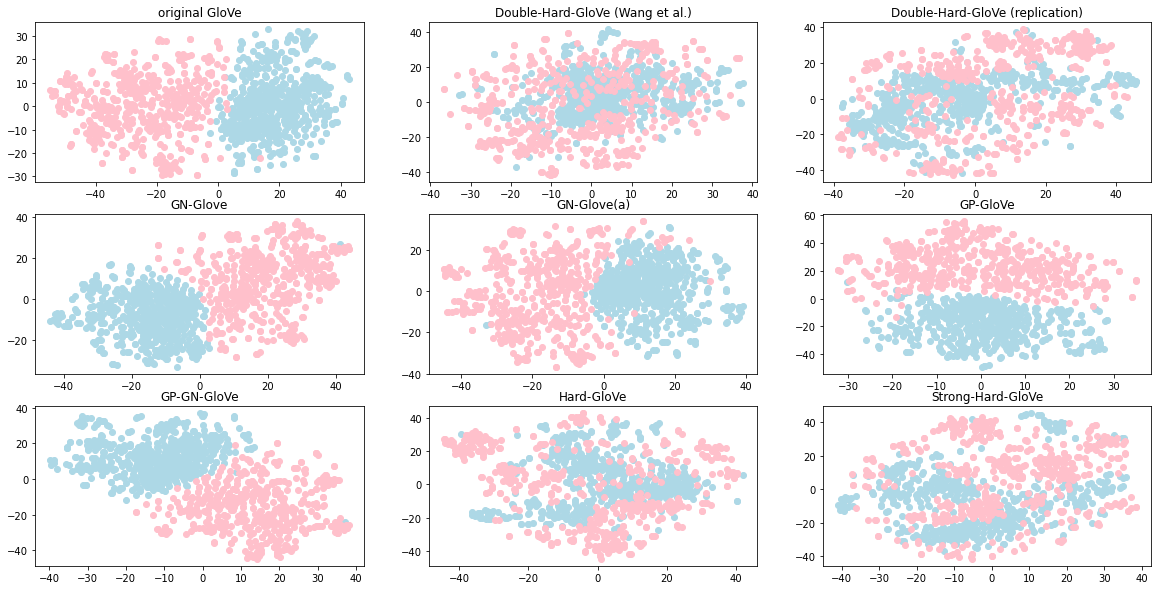

In [12]:
# create pd dataframe from tsne_results dictionary:
results_TSNE = pd.DataFrame.from_dict(tsne_results)
results_TSNE.to_csv('evaluation_results/results_tsne.csv')
results_TSNE

# plot tsne results:
fig, axes = plt.subplots(nrows=3, ncols=3, **dict(figsize=(20, 10)))
for i, (key, (tsne_fem, tsne_male)) in enumerate(tsne_results.items()):
    if i < 3:
        axes[0, i].set_title(key)
        axes[0, i].scatter(x = tsne_fem[:,0], y = tsne_fem[:,1], color='lightblue')
        axes[0, i].scatter(x = tsne_male[:,0], y = tsne_male[:,1], color='pink')
    elif i < 6: 
            axes[1, (i-3)].set_title(key)
            axes[1, (i-3)].scatter(x = tsne_fem[:,0], y = tsne_fem[:,1], color='lightblue')
            axes[1, (i-3)].scatter(x = tsne_male[:,0], y = tsne_male[:,1], color='pink')
    else:
        axes[2, (i-6)].set_title(key)
        axes[2, (i-6)].scatter(x = tsne_fem[:,0], y = tsne_fem[:,1], color='lightblue')
        axes[2, (i-6)].scatter(x = tsne_male[:,0], y = tsne_male[:,1], color='pink')
fig.savefig("evaluation_results/results_tsne.png")            
plt.show()

## Word Analogy
The word analogy task is to find a word *D* such that "*A* is to *B* as *C* is to *D*". Wang et al. (2020) have evaluated all non-debiased and debiased embeddings on the MSR word analogy task [Mikolov et al., 2013a](https://www.aclweb.org/anthology/N13-1090/) as well as on a second Google word analogy dataset [Mikolov et al. 2013b](https://arxiv.org/abs/1301.3781v3). The evaluation metric is the percentage of questions for which the correct answer is assigned the maximum score by the algorithm. The analogy task is used to show whether a debiasing method is capable of preserving desired distance relations between words. The implementation was taken from Wang et al. (2020) with some adjustments to get it running: `analogy_tasks.py`

### MSR

In [13]:
# MSR on all embeddings:
results_msr = []
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    print(key + ":")
    result = ana.evaluate_analogy_msr(embedding, vocab, w2id)
    results_msr.append(result)
    print()
    
results_MSR = pd.DataFrame(data = results_msr, index = list(dict_embeddings.keys()), columns = ["MSR"])
results_MSR.to_csv('evaluation_results/results_msr.csv')
results_MSR

original GloVe:
4884
ACCURACY TOP1-MSR: 54.40% (2657/4884)

Double-Hard-GloVe (Wang et al.):
6750
ACCURACY TOP1-MSR: 42.40% (2862/6750)

Double-Hard-GloVe (replication):
4884
ACCURACY TOP1-MSR: 62.12% (3034/4884)

GN-Glove:
6750
ACCURACY TOP1-MSR: 44.10% (2977/6750)

GN-Glove(a):
6750
ACCURACY TOP1-MSR: 43.26% (2920/6750)

GP-GloVe:
6750
ACCURACY TOP1-MSR: 42.36% (2859/6750)

GP-GN-GloVe:
6750
ACCURACY TOP1-MSR: 44.65% (3014/6750)

Hard-GloVe:
6750
ACCURACY TOP1-MSR: 54.27% (3663/6750)

Strong-Hard-GloVe:
6750
ACCURACY TOP1-MSR: 53.94% (3641/6750)



,MSR
original GloVe,0.544021
Double-Hard-GloVe (Wang et al.),0.424000
Double-Hard-GloVe (replication),0.621212
GN-Glove,0.441037
GN-Glove(a),0.432593
GP-GloVe,0.423556
GP-GN-GloVe,0.446519
Hard-GloVe,0.542667
Strong-Hard-GloVe,0.539407


In [14]:
# Google analogy task on all embeddings:
results_google = []
for key, (embedding, vocab, w2id) in dict_embeddings.items():
    print(key + ":\n")
    (sem, syn, total) = ana.evaluate_analogy_google(embedding, vocab, w2id)
    results_google.append(sem)
    results_google.append(syn)
    results_google.append(total)
    print("\n")
    
results_google = np.asarray(results_google).reshape(9, 3)
results_GG = pd.DataFrame(data = results_google, index = list(dict_embeddings.keys()), columns = ["Sem", "Syn", "Total"])
results_GG.to_csv('evaluation_results/results_gg.csv')
results_GG

original GloVe:

capital-common-countries.txt:
ACCURACY TOP1: 98.95% (283/286)
capital-world.txt:
ACCURACY TOP1: 94.69% (1409/1488)
currency.txt:
ACCURACY TOP1: 7.63% (18/236)
city-in-state.txt:
ACCURACY TOP1: 77.49% (1855/2394)
family.txt:
ACCURACY TOP1: 71.67% (301/420)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 9.25% (86/930)
gram2-opposite.txt:
ACCURACY TOP1: 29.22% (135/462)
gram3-comparative.txt:
ACCURACY TOP1: 78.68% (1048/1332)
gram4-superlative.txt:
ACCURACY TOP1: 46.55% (378/812)
gram5-present-participle.txt:
ACCURACY TOP1: 47.42% (441/930)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 93.23% (1418/1521)
gram7-past-tense.txt:
ACCURACY TOP1: 34.87% (544/1560)
gram8-plural.txt:
ACCURACY TOP1: 75.46% (898/1190)
gram9-plural-verbs.txt:
ACCURACY TOP1: 45.57% (370/812)
Questions seen/total: 73.54% (14373/19544)
Semantic accuracy: 80.14%  (3866/4824)
Syntactic accuracy: 55.69%  (5318/9549)
Total accuracy: 63.90%  (9184/14373)


Double-Hard-GloVe (Wang et al.):

capital-common-c

gram6-nationality-adjective.txt:
ACCURACY TOP1: 91.99% (1471/1599)
gram7-past-tense.txt:
ACCURACY TOP1: 56.54% (882/1560)
gram8-plural.txt:
ACCURACY TOP1: 75.68% (1008/1332)
gram9-plural-verbs.txt:
ACCURACY TOP1: 58.28% (507/870)
Questions seen/total: 86.90% (16984/19544)
Semantic accuracy: 71.23%  (4494/6309)
Syntactic accuracy: 62.43%  (6664/10675)
Total accuracy: 65.70%  (11158/16984)




,Sem,Syn,Total
original GloVe,0.801410,0.556917,0.638976
Double-Hard-GloVe (Wang et al.),0.713584,0.479906,0.566710
Double-Hard-GloVe (replication),0.802032,0.665515,0.711334
GN-Glove,0.692820,0.510070,0.577956
GN-Glove(a),0.689967,0.506417,0.574600
GP-GloVe,0.735299,0.515504,0.597150
GP-GN-GloVe,0.694405,0.531803,0.592204
Hard-GloVe,0.736250,0.627447,0.667864
Strong-Hard-GloVe,0.712316,0.624262,0.656971
